In [309]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

In [310]:
df = pd.read_csv('Данные по использованию климатических систем.csv', sep=';')

In [311]:
params = {'text.color': "white", "font.size": 12}
plt.rcParams.update(params)
plt.tight_layout()
sns.set(style="whitegrid", font_scale=1.5)

<Figure size 640x480 with 0 Axes>

In [312]:
# PEP8

def make_word_pep8style(word: str) -> str:
    return word.lower().replace(' ', '_')

df = df.rename(make_word_pep8style, axis='columns')

list(df.columns)

['год',
 'время_года',
 'климат',
 'город',
 'страна',
 'способ_охлаждения',
 'режим_при_смешанном_типе_охлаждения',
 'способ_обогрева',
 'возраст',
 'пол',
 'ощущение_температуры',
 'ощущение_температуры_(bool)',
 'предпочтительное_изменение_температуры',
 'ощущение_движения_воздуха_(bool)',
 'предпочтительное_изменение_движения_воздуха',
 'оценка_комфорта',
 'утепление',
 'температура_воздуха_в_помещении',
 'температура_воздуха_на_улице',
 'rh',
 'скорость_воздуха',
 'рост',
 'вес',
 'занавески',
 'вентилятор',
 'окно',
 'двери',
 'отопление',
 'среднемесячная_температура_на_улице',
 'количество_рекламаций']

# Исследование данных на качество и предобработка

Разделим данные на числовые и категориальные

In [313]:
numerical = [
    'возраст',
    'температура_воздуха_в_помещении',
    'температура_воздуха_на_улице',
    'rh',
    'скорость_воздуха',
    'рост',
    'вес',
    'среднемесячная_температура_на_улице',
    'количество_рекламаций',
    'утепление',
    'ощущение_температуры',
    'оценка_комфорта',
]
categorial = list(set(df.columns) ^ set(numerical))

categorial_bool = [
    'ощущение_температуры_(bool)',
    'занавески',
    'вентилятор',
    'окно',
    'двери',
    'отопление'
]

## Первичный графический анализ

для поиска используя графический метод в категориальных факторах используем круговую диаграмму, а в количественных гистограммы и ящик с усами (boxplot)

### Для каждого числового столбца построим гистограмму и ящик с усами

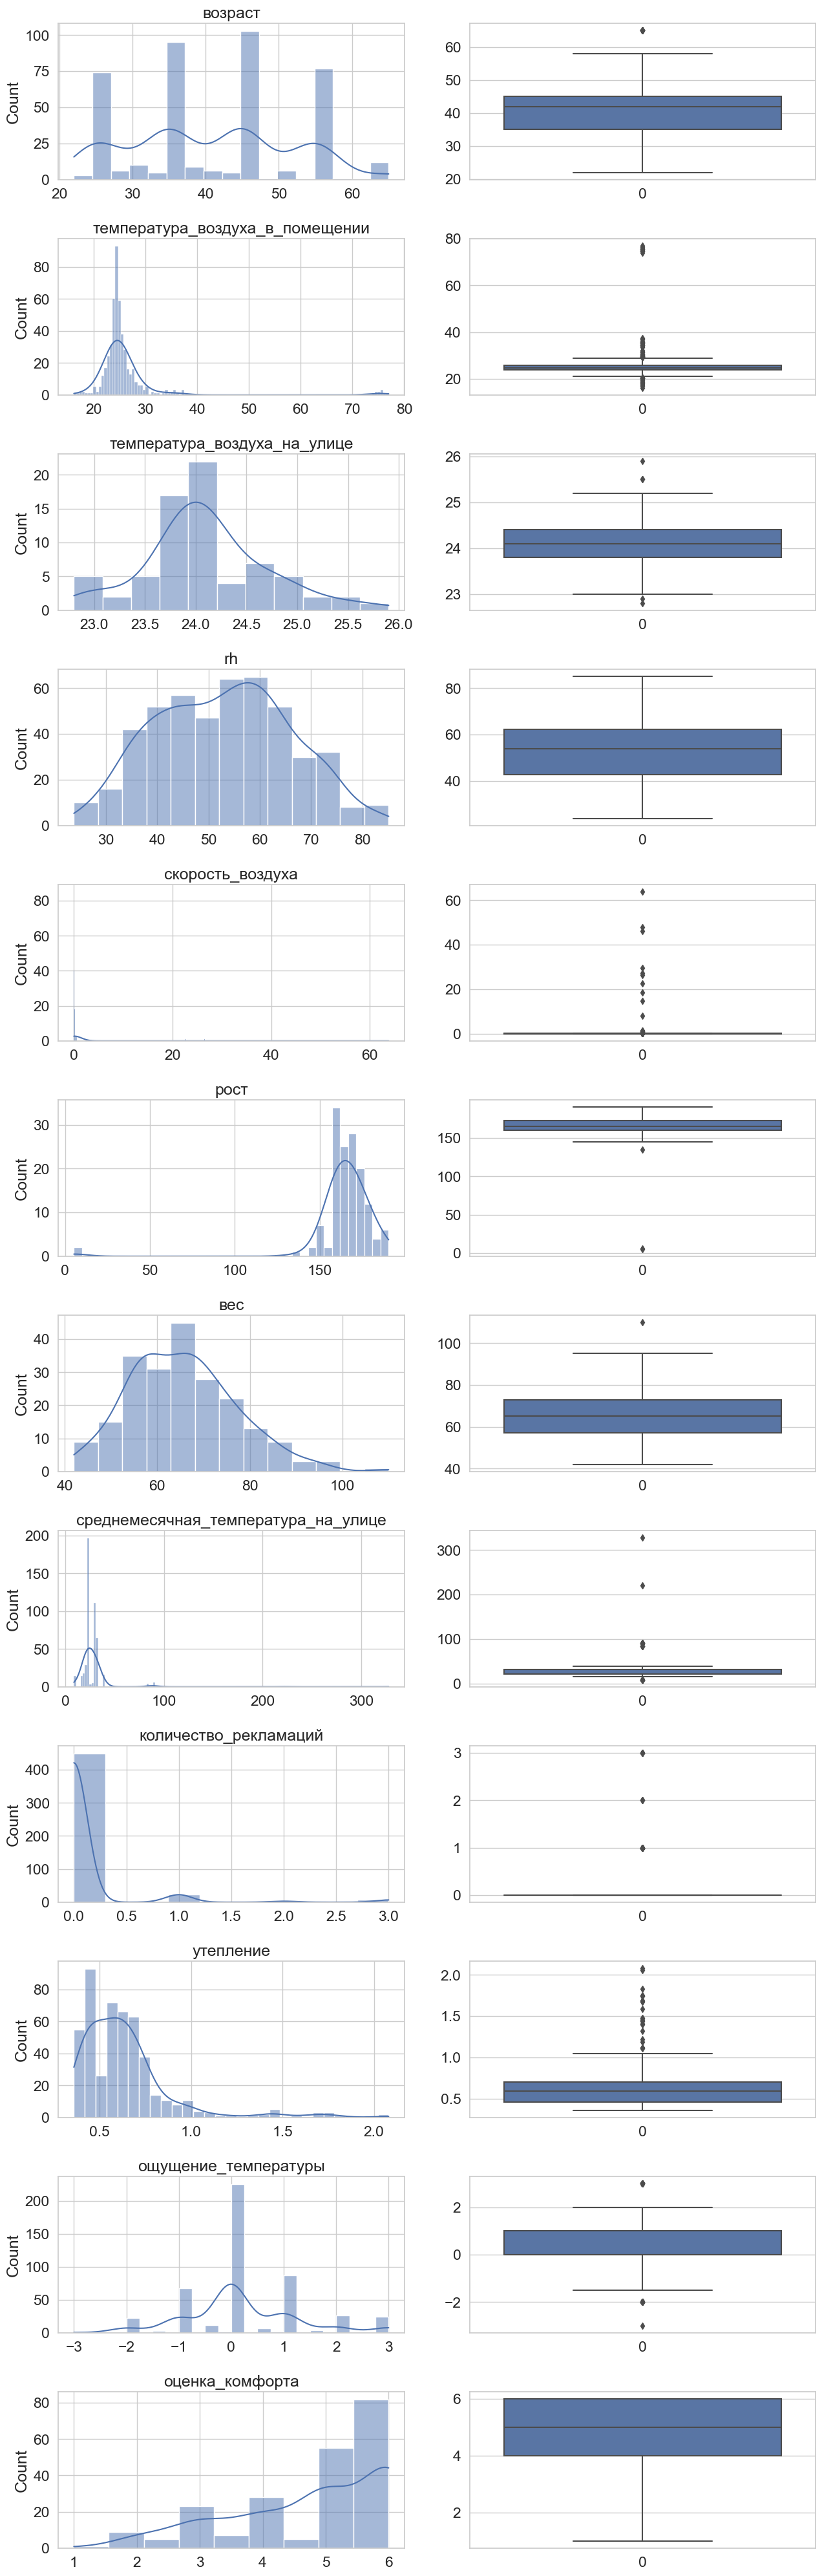

In [314]:
fig, ax = plt.subplots(len(numerical), 2)
fig.set_figheight(40)
fig.set_figwidth(13)
fig.tight_layout(h_pad=2)

for i, col in enumerate(numerical):
    sns.histplot(df[col], kde=True, ax=ax[i][0])
    sns.boxplot(df[col], ax=ax[i][1])
    ax[i][0].set_xlabel("")
    ax[i][0].set_title(col)

### А для каждого категориального столбца построим круговую диаграму

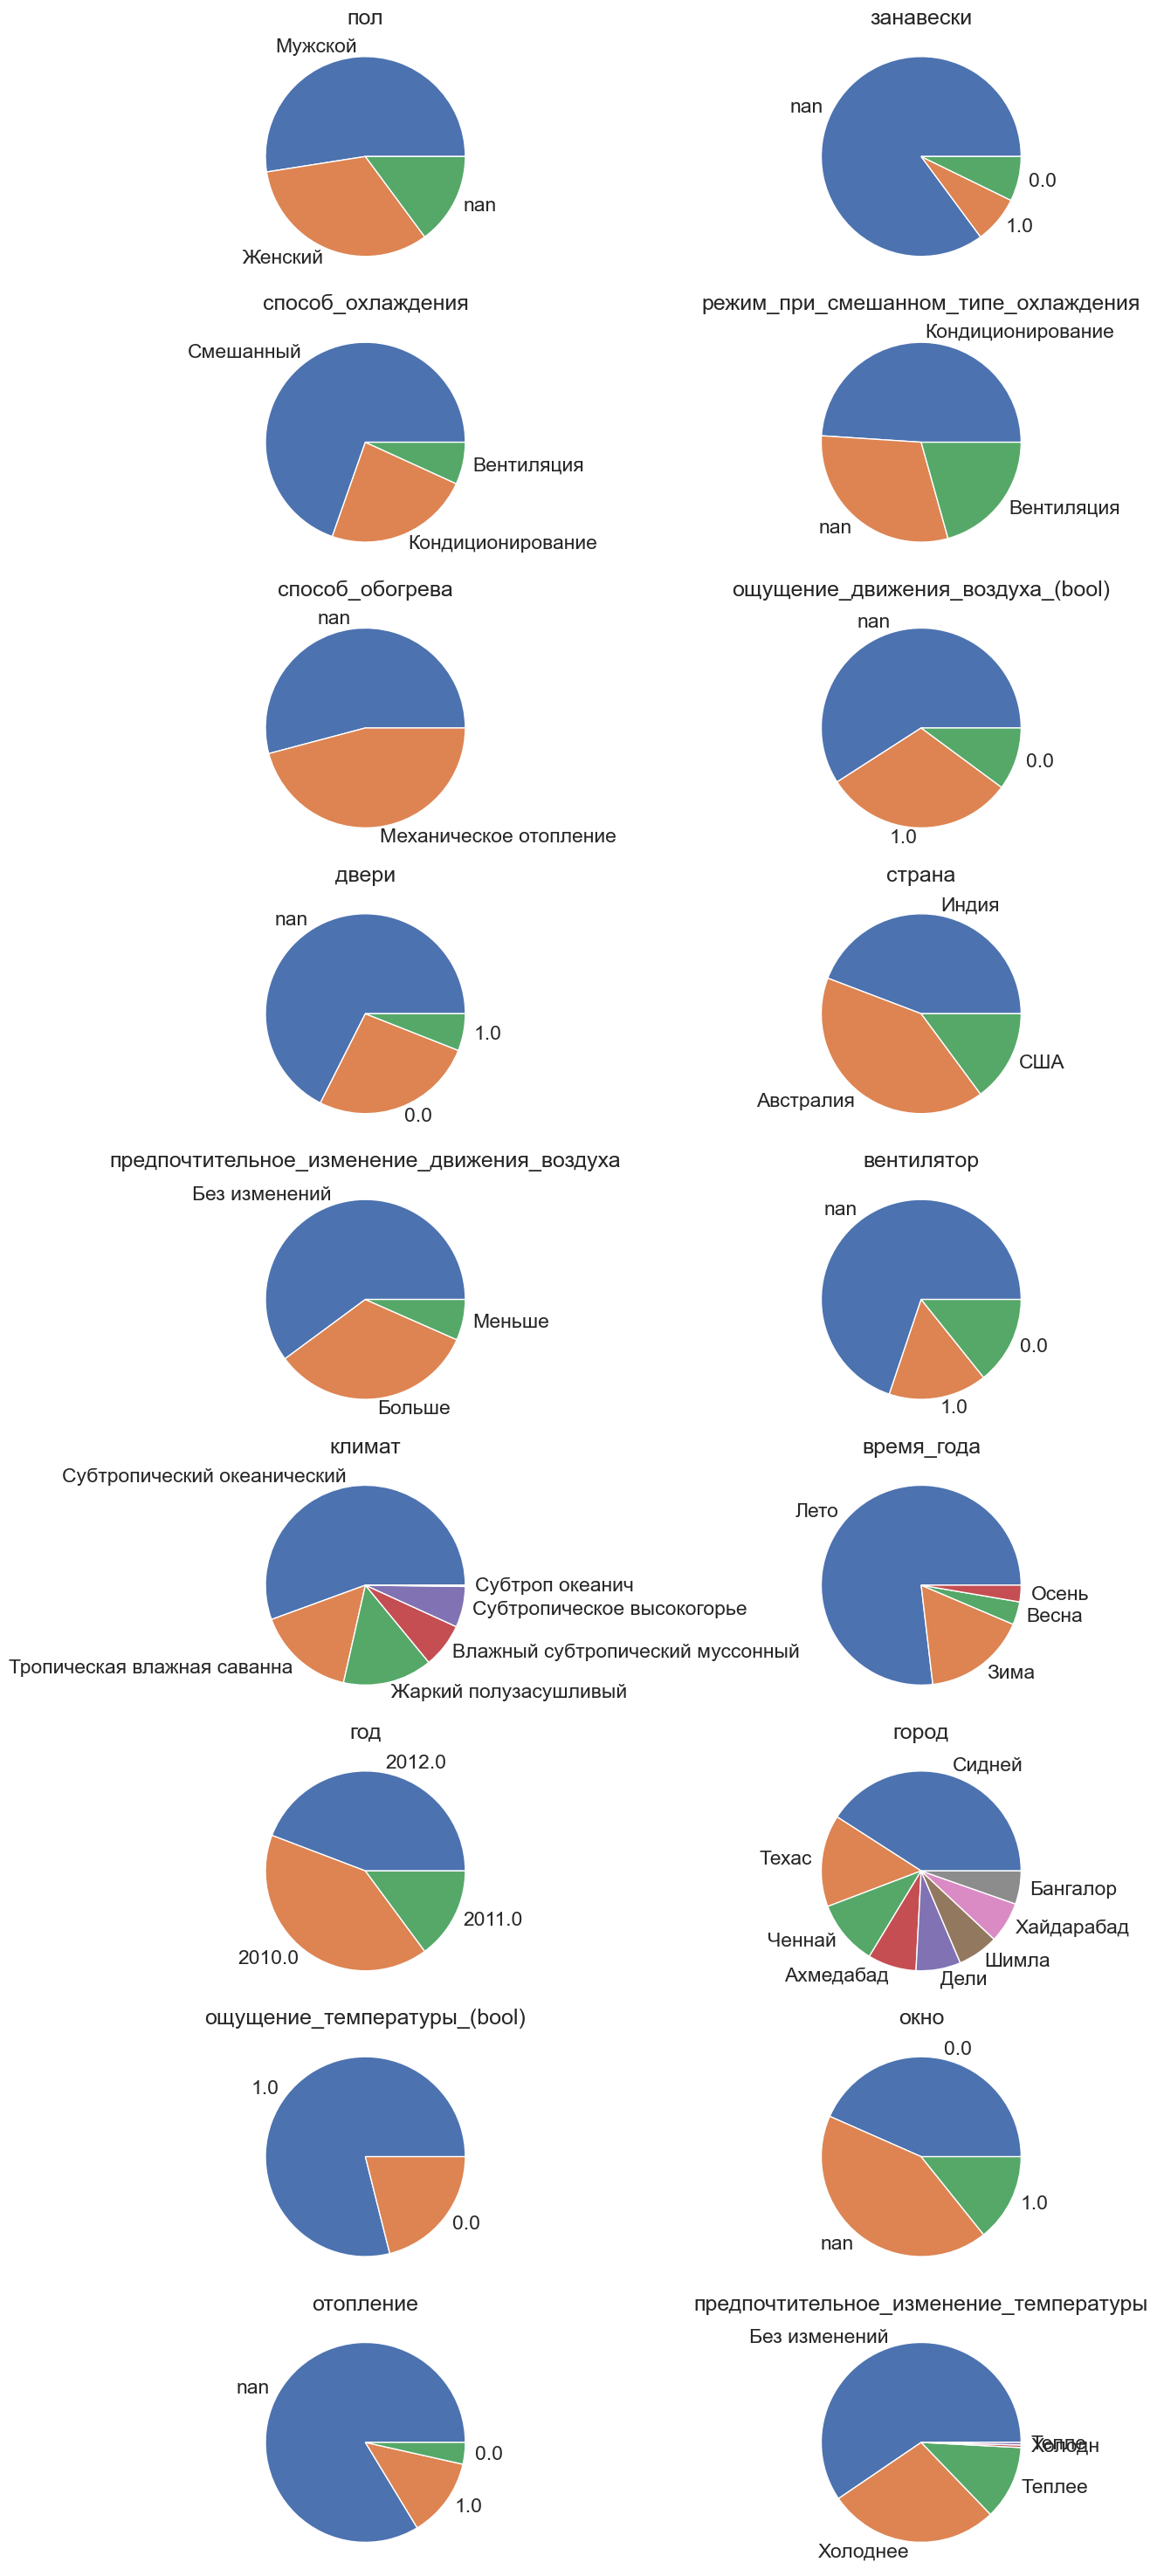

In [315]:
fig, ax = plt.subplots((len(categorial) + 1) // 2, 2)
fig.set_figheight(30)
fig.set_figwidth(13)
fig.tight_layout(h_pad=0)
for i, col in enumerate(categorial):
    value_counts = pd.value_counts(df[col], dropna=False)
    ax[i // 2][i % 2].pie(value_counts, labels=value_counts.index)
    ax[i // 2][i % 2].set_title(col)

## Исправление орфографических ошибок (task2)

Обнаружены орфографические ошибки:
- В столбце **"предпочтительное_изменение_температуры"** *"Тепле"* и *"Холодн"*
- В столбце **"климат"** *"Субтроп океанич"*

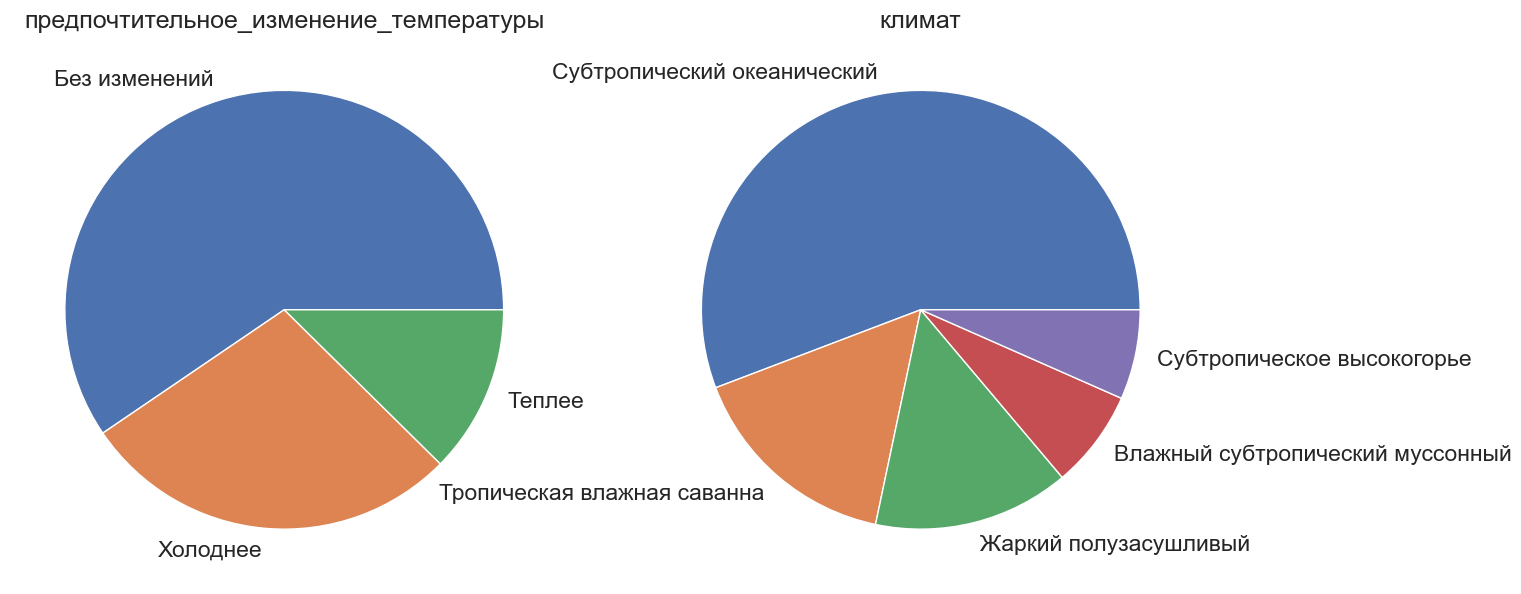

In [316]:
def fix_spelling_1st_problem(word: str) -> str:
    return "Теплее" if word == "Тепле" else "Холоднее" if word == "Холодн" else word
 
def fix_spelling_2nd_problem(word: str) -> str:
    return "Cубтропический океанический" if word == "Cубтроп океанич" else word

df["предпочтительное_изменение_температуры"] = df["предпочтительное_изменение_температуры"].apply(fix_spelling_1st_problem)
df["климат"] = df["климат"].apply(fix_spelling_2nd_problem)

# Проверка 

columns = ['предпочтительное_изменение_температуры', 'климат']

fig, ax = plt.subplots(1, 2)
fig.set_figheight(30)
fig.set_figwidth(13)
fig.tight_layout(h_pad=0)
for ind, col in enumerate(columns):
    value_counts = pd.value_counts(df[col], dropna=False)
    ax[ind].pie(value_counts, labels=value_counts.index)
    ax[ind].set_title(col)

## Исправление выбросов в росте (task5)

рост ~140 см считаем не аномалией

Text(0.5, 1.0, 'рост')

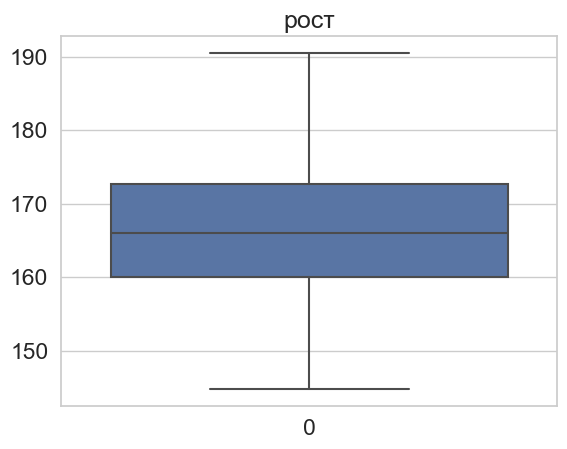

In [317]:
def fix_height(num: int) -> int:
    return None if num < 135 else num

df['рост'] = df['рост'].apply(fix_height)

fig, ax = plt.subplots()
sns.boxplot(df['рост'], ax=ax)
ax.set_title("рост")

## Исправление выбросов в скорости воздуха (task5)

скорость > 5 м/с в помещении считаем аномальной

<Axes: >

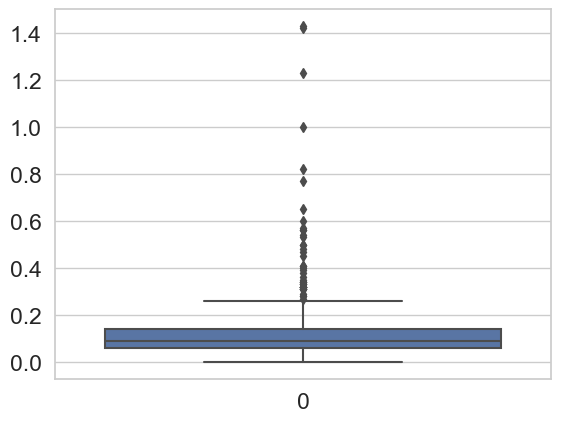

In [318]:
# заменяем все показания в колонке скорость воздуха больше 30 на None, ибо такие показатели аномальные
df['скорость_воздуха'] = df['скорость_воздуха'].apply(lambda x: None if x > 5 or x is None else x)

sns.boxplot(df['скорость_воздуха'])

## Исследование колонок с температурой (task5)

Исследуем аномалии используя boxplot

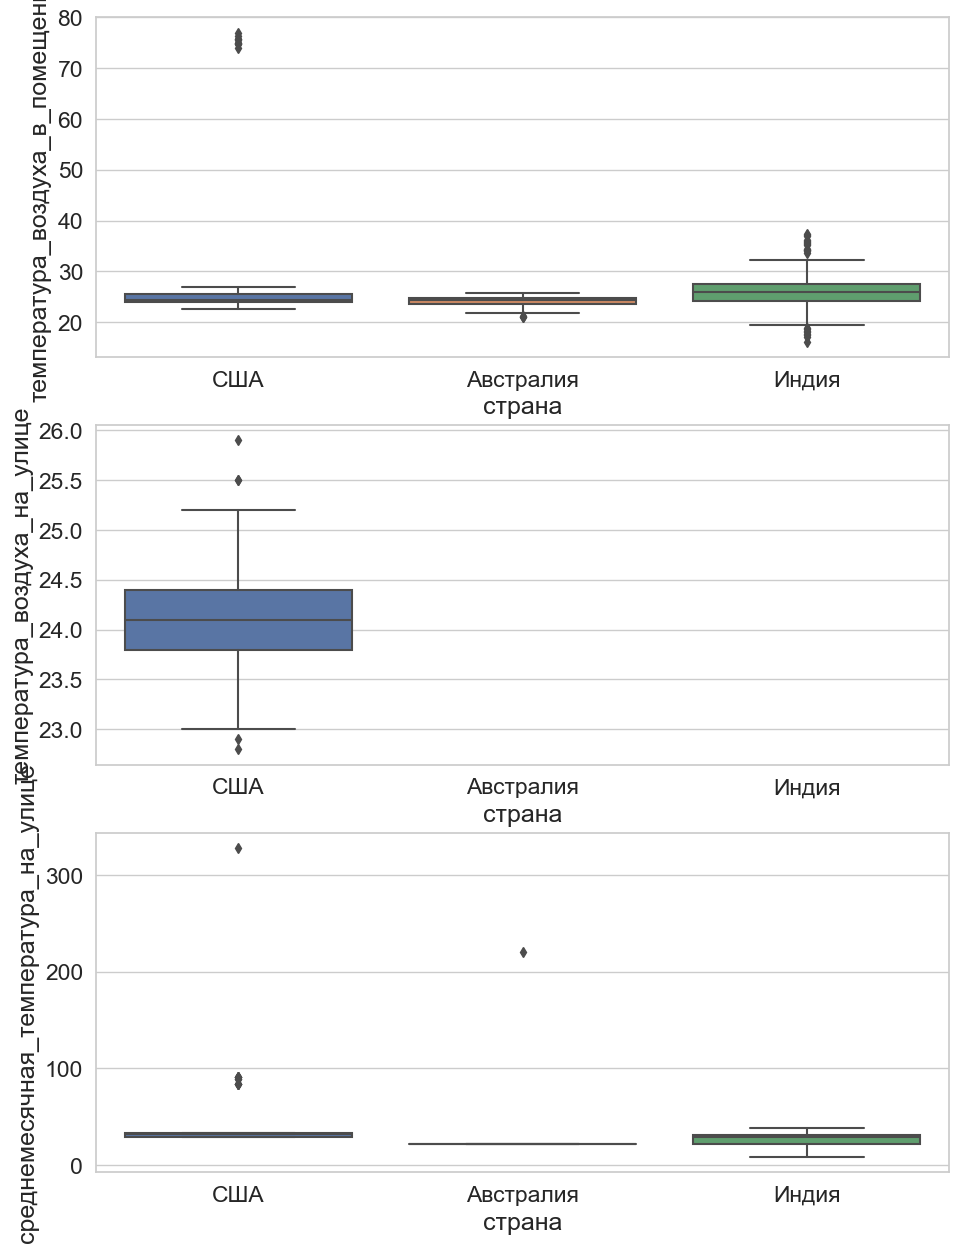

In [319]:
temperature_cols = [
    'температура_воздуха_в_помещении',
    'температура_воздуха_на_улице',
    'среднемесячная_температура_на_улице'
]
fig, ax = plt.subplots(3, 1)
fig.set_figwidth(11)
fig.set_figheight(15)
for i, col in enumerate(temperature_cols):
    sns.boxplot(data=df, x='страна', y=col, ax=ax[i])

Заметим, что у США наблюдаются выбросы в большую сторону. Предположим, что температура указана в °F. Тогда конвертируем все значения больше 40 из °F в °C. 

<Axes: xlabel='страна', ylabel='температура_воздуха_в_помещении'>

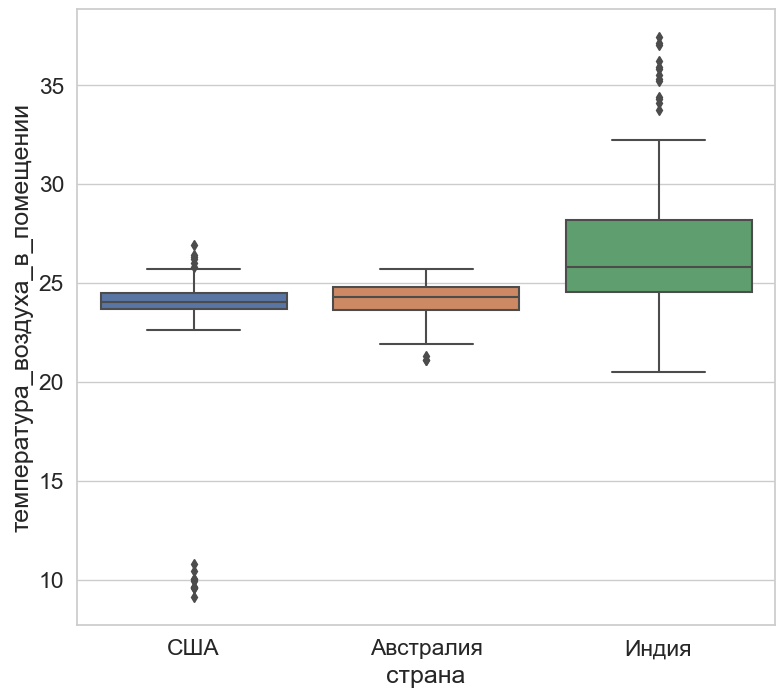

In [320]:
def f2c(row):
    if row[17] is None:
        return None
    
    if row[4] == 'США':
        if row[17] > 40:
            return row[17] * 5 / 9 - 32
    return row[17]

df_new = pd.DataFrame()
df_new['страна'] = df['страна']
df_new['время_года'] = df['время_года']
df_new['температура_воздуха_в_помещении'] = df.apply(f2c, axis=1)
# print(df_new[df_new['время_года'] == 'Лето'])
fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(9)
sns.boxplot(data=df_new[df_new['время_года'] == 'Лето'], x='страна', y='температура_воздуха_в_помещении', ax=ax)

Поскольку после приведения температуры из °F в °C, оказалось, что в США летом температура в помещении составила в нижней квартили 12°C, поэтому гипотезу отвергаем. Значит мы имеем дело с выбросами

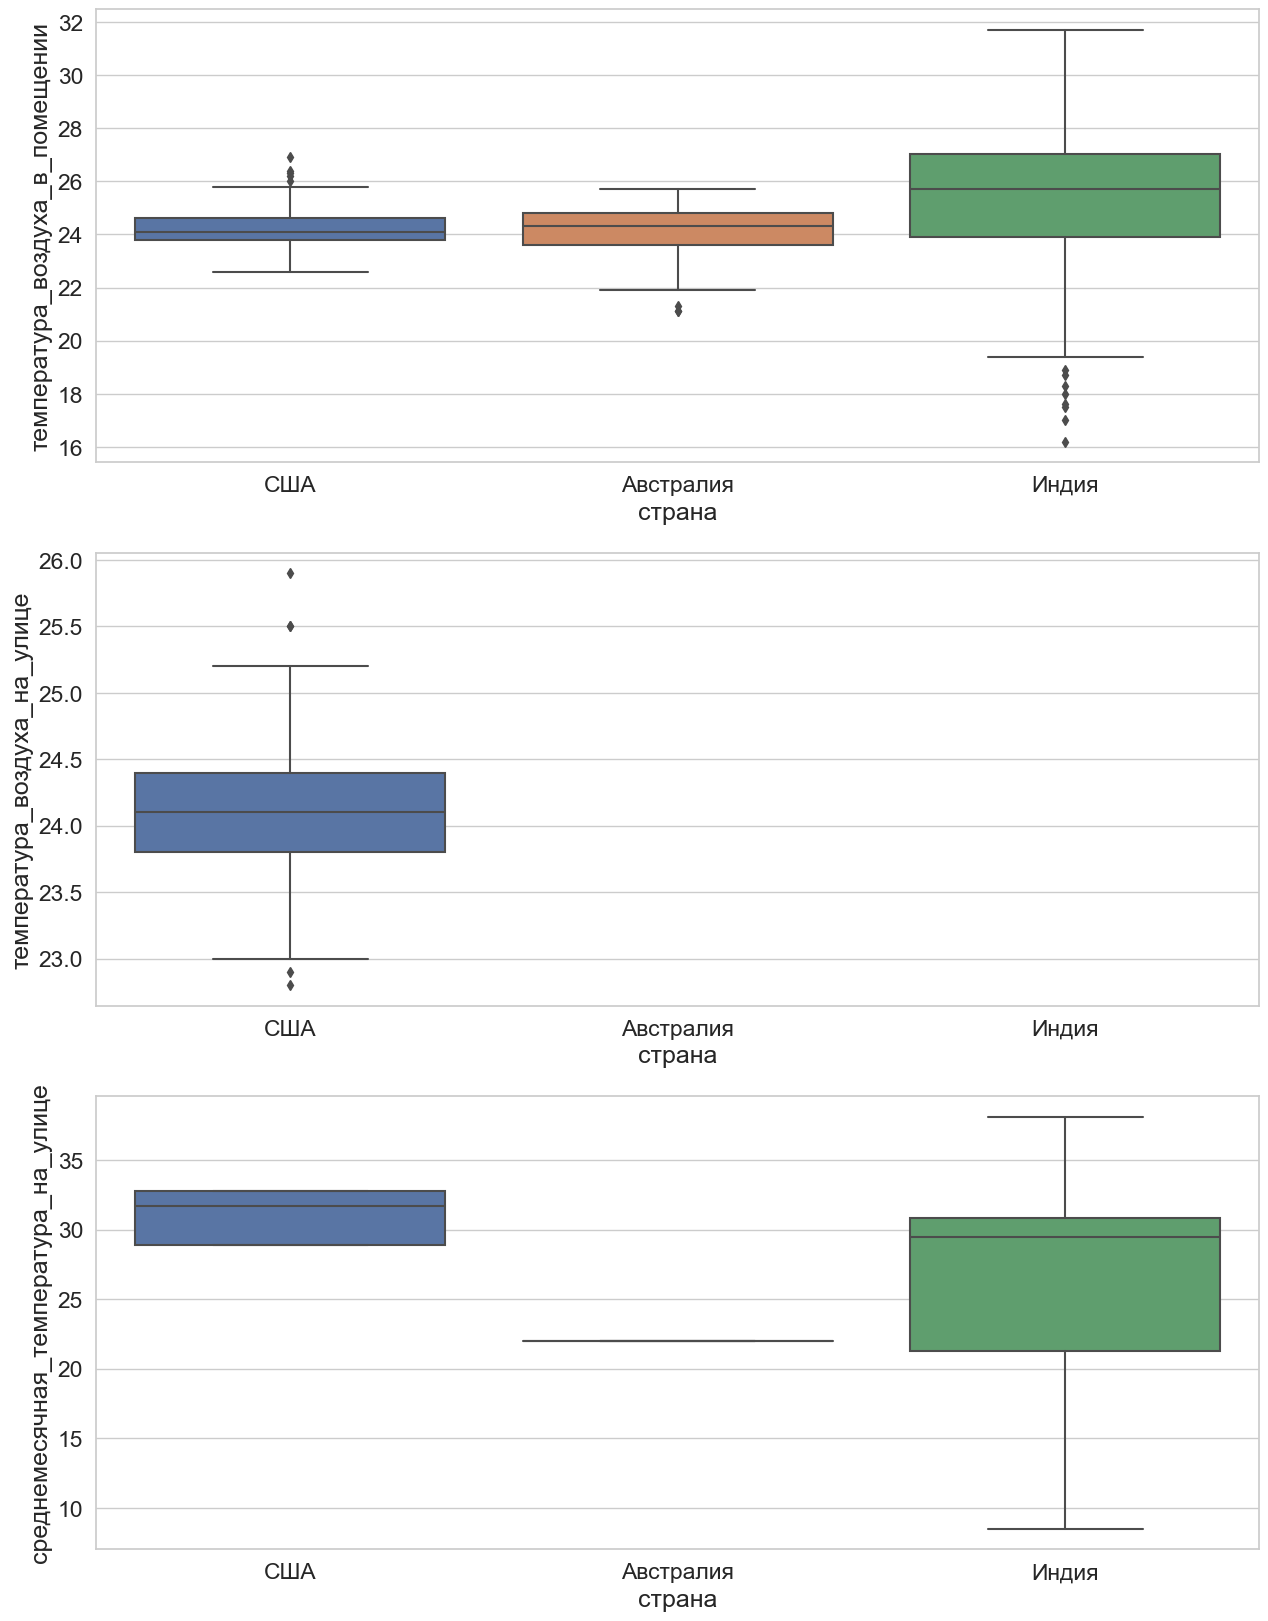

In [321]:
def chnge_temperature(row, c):
    season = ['Лето', 'Зима', 'Осень', 'Весна']
    season_idx = season.index(row[1])
    col_idx = list(row.index).index(c)
    if lower_bound[season_idx] <= row[col_idx] <= upper_bound[season_idx]:
        return row[col_idx]
    return None



for col in temperature_cols:
    Q1 = [
        df[df['время_года'] == 'Лето'][col].quantile(0.25),
        df[df['время_года'] == 'Зима'][col].quantile(0.25),
        df[df['время_года'] == 'Осень'][col].quantile(0.25),
        df[df['время_года'] == 'Весна'][col].quantile(0.25),
    ]
    Q3 = [
        df[df['время_года'] == 'Лето'][col].quantile(0.75),
        df[df['время_года'] == 'Зима'][col].quantile(0.75),
        df[df['время_года'] == 'Осень'][col].quantile(0.75),
        df[df['время_года'] == 'Весна'][col].quantile(0.75),
    ]
    IQR = [
        Q3[0] - Q1[0],
        Q3[1] - Q1[1],
        Q3[2] - Q1[2],
        Q3[3] - Q1[3],
    ]
    lower_bound = [
        Q1[0] - 3 * IQR[0],
        Q1[1] - 3 * IQR[1],
        Q1[2] - 3 * IQR[2],
        Q1[3] - 3 * IQR[3]
    ]
    upper_bound = [
        Q3[0] + 3 * IQR[0],
        Q3[1] + 3 * IQR[1],
        Q3[2] + 3 * IQR[2],
        Q3[3] + 3 * IQR[3],
    ]
    df[col] = df.apply(chnge_temperature, axis=1, c=col)

fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(20)
for i, col in enumerate(temperature_cols):
    sns.boxplot(data=df, x='страна', y=col, ax=ax[i])

In [322]:
df.isna().sum()

год                                              0
время_года                                       0
климат                                           0
город                                            0
страна                                           0
способ_охлаждения                                0
режим_при_смешанном_типе_охлаждения            147
способ_обогрева                                262
возраст                                         71
пол                                             72
ощущение_температуры                             0
ощущение_температуры_(bool)                      0
предпочтительное_изменение_температуры           0
ощущение_движения_воздуха_(bool)               286
предпочтительное_изменение_движения_воздуха      0
оценка_комфорта                                269
утепление                                        0
температура_воздуха_в_помещении                 28
температура_воздуха_на_улице                   412
rh                             

## Обработка дубликатов (удаляем) (task4)

In [323]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()

False    482
True       2
Name: count, dtype: int64


In [324]:
def change_kind_of_cooling(row):
    if row['режим_при_смешанном_типе_охлаждения'] == 'Кондиционирование':
        return 'Кондиционирование'
    elif row['режим_при_смешанном_типе_охлаждения'] == 'Вентиляция':
        return 'Вентиляция'
    return row['способ_охлаждения']

df['способ_охлаждения'] = df.apply(change_kind_of_cooling, axis='columns')
df = df.drop('режим_при_смешанном_типе_охлаждения', axis=1)
categorial.remove('режим_при_смешанном_типе_охлаждения')

## Заполнение пропусков
Числовые пропуски заполняем сейчас, поскольку их довольно мало. Категориальные пропуски не трогаем до тех пор, пока не начнем с ними работать.

In [325]:
'количество строк, которые имеют пропуски:', len(df[df['возраст'].isna()])

('количество строк, которые имеют пропуски:', 69)

#### Возраст

In [326]:
countries = df.groupby('страна')

In [327]:
def fillna_age(row):
    if pd.isnull(row.loc['возраст']):
        return age_median[row.loc['страна']]
    return row.loc['возраст']


age_median = countries['возраст'].median()
df['возраст'] = df.apply(fillna_age, axis=1)

#### Скорость воздуха

In [328]:
wind_velocity_median = df['скорость_воздуха'].median()
df['скорость_воздуха'] = df['скорость_воздуха'].apply(lambda x: wind_velocity_median if x is None else x)

#### Температура воздуха в помещении

In [329]:
groups = df.groupby(['год', 'время_года', 'город'])['температура_воздуха_в_помещении'].median()

def fix_skips_temp_inside(row):
    if pd.isna(row['температура_воздуха_в_помещении']):
        return groups[row['год'], row['время_года'], row['город']]
    return row['температура_воздуха_в_помещении']

df['температура_воздуха_в_помещении'] = df.apply(fix_skips_temp_inside, axis=1)

#### Среднемесячная температура на улице

In [330]:
temperature_groups = df.groupby(['город', 'год', 'время_года'])['среднемесячная_температура_на_улице'].median()
print(temperature_groups)

temperature_groups['Хайдарабад', 2012, 'Осень'] = (
    temperature_groups['Хайдарабад', 2012, 'Лето'] + temperature_groups['Хайдарабад', 2012, 'Зима']
) / 2

город       год     время_года
Ахмедабад   2012.0  Зима          21.3
                    Лето          29.5
Бангалор    2012.0  Зима          29.9
                    Лето          30.8
Дели        2012.0  Зима          15.5
                    Лето          30.9
Сидней      2010.0  Лето          22.0
Техас       2011.0  Лето          31.7
Хайдарабад  2012.0  Весна         31.5
                    Зима          21.6
                    Лето          27.0
                    Осень          NaN
Ченнай      2012.0  Весна         30.4
                    Зима          30.8
                    Лето          38.1
                    Осень         29.7
Шимла       2012.0  Зима           8.5
                    Лето          18.5
Name: среднемесячная_температура_на_улице, dtype: float64


In [331]:
def fillna_age(row):
    if pd.isnull(row['среднемесячная_температура_на_улице']):
        return temperature_groups[row['город'], row['год'], row['время_года']]
    return row['среднемесячная_температура_на_улице']


df['среднемесячная_температура_на_улице'] = df.apply(fillna_age, axis=1)

In [332]:
# tools
def show_pie_charts(_col1, _col2):
    global df
    _columns = sorted(df[_col1].dropna().unique())
    _colors = ['green', 'blue', 'orange', 'pink', 'magenta', 'purple', 'red']
    _all_possible_values = df[_col2].unique()

    fig, ax = plt.subplots(len(_columns), 1)
    fig.set_figheight(15)
    fig.set_figwidth(10)
    fig.tight_layout(h_pad=0)
  
    for _ind, _col in enumerate(_columns):
        _vals = df[df[_col1] == _col][_col2].value_counts(dropna=True)
        wedges, _ = ax[_ind].pie(_vals, colors=_colors)
        ax[_ind].set_title(_col2)
        ax[_ind].legend(wedges, _all_possible_values,
          title=_col1 + ' = ' + str(_col),
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Проведение расчётов и исследований

## Создание категориального стоблца кол-ва рекламаций (task6)

In [333]:
df['количество_рекламаций_кат'] = ['мало' if i <= 1 else ('средне' if i == 2 else 'много') for i in df['количество_рекламаций']]
df

,год,время_года,климат,город,страна,способ_охлаждения,способ_обогрева,возраст,пол,ощущение_температуры,...,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,количество_рекламаций_кат
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,22.0,NaN,0.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0,мало
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,40.0,NaN,-2.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,31.7,0,мало
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,42.0,NaN,1.0,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0,мало
3,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,27.0,NaN,-0.5,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1,мало
4,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,46.0,NaN,0.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0,мало
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,2012.0,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Вентиляция,NaN,35.0,Мужской,1.0,...,NaN,56.0,NaN,NaN,0.0,0.0,NaN,21.6,0,мало
478,2012.0,Лето,Тропическая влажная саванна,Ченнай,Индия,Кондиционирование,NaN,35.0,Мужской,1.0,...,NaN,60.0,NaN,NaN,0.0,0.0,NaN,38.1,0,мало
479,2012.0,Лето,Влажный субтропический муссонный,Дели,Индия,Вентиляция,NaN,35.0,Мужской,0.0,...,172.7,50.0,NaN,1.0,1.0,NaN,0.0,30.9,0,мало
480,2012.0,Зима,Тропическая влажная саванна,Ченнай,Индия,Кондиционирование,NaN,35.0,Мужской,-1.0,...,NaN,65.0,NaN,NaN,0.0,0.0,NaN,30.8,0,мало


## Создание категориального столбца по возрастным группам (task 9)

In [334]:
df['возрастная_группа'] = ['молодой возраст' if i <= 44 else ('средний возраст' if 45 <= i <= 59 else 'пожилой возраст') for i in df['возраст']]

## Расчёт средней комфортной температуры в зависимости от возрастной категории (task7)

In [335]:
df[df['ощущение_температуры_(bool)'] == 1].groupby(['возрастная_группа'])['температура_воздуха_в_помещении'].mean()

возрастная_группа
молодой возраст    24.940969
пожилой возраст    25.400000
средний возраст    23.965972
Name: температура_воздуха_в_помещении, dtype: float64

## Средний возраст респондентов по полу и стране (task 8)

По полу:

In [336]:
df.groupby('пол')['возраст'].mean()

пол
Женский    41.923077
Мужской    39.566929
Name: возраст, dtype: float64


По стране:

In [337]:
df.groupby('страна')['возраст'].mean()

страна
Австралия    44.292929
Индия        36.886792
США          36.208333
Name: возраст, dtype: float64

In [338]:
print(df.groupby(['страна', 'пол'])['возраст'].mean())

страна     пол    
Австралия  Женский    46.348315
           Мужской    42.614679
Индия      Женский    36.044776
           Мужской    37.275862
Name: возраст, dtype: float64


## Медианное значение влажности и температуры для каждого типа охлаждения (task 10)

In [339]:
df.groupby('способ_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median()

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,24.0,53.5
Кондиционирование,24.6,54.1


## Сводная таблица с данными, сгрупированными по стране, полу, возрастной группе(Task 11)

In [340]:
print(df.groupby(['страна', 'пол', 'возрастная_группа'])[['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh']].mean())

                                     температура_воздуха_в_помещении  \
страна    пол     возрастная_группа                                    
Австралия Женский молодой возраст                          23.840000   
                  пожилой возраст                          24.900000   
                  средний возраст                          24.112500   
          Мужской молодой возраст                          24.146667   
                  пожилой возраст                          24.733333   
                  средний возраст                          24.044262   
Индия     Женский молодой возраст                          25.998077   
                  средний возраст                          23.113333   
          Мужской молодой возраст                          25.727000   
                  пожилой возраст                          29.300000   
                  средний возраст                          24.118182   

                                     температура_воздуха_на_ули

## Стандартная комфортная относительная влажность в помещениях (task 13)
- Согласно [СанПиН 2.2.4.548—96](https://kpfu.ru/portal/docs/F_979595184/SanPiN.2.2.4.548_96.o.mikroklimate.pdf) оптимальная влажность в рабочих помещениях в теплое и холодное время года должна составлять от $40\% - 60 \%$.
- Однако, согласно Управлению по охране труда США (Occupational Safety and Health Administration, OSHA) оптимальная влажность должна лежать в диапазоне от $20\% - 60\%$. [Ссылка на положение](https://www.osha.gov/laws-regs/standardinterpretations/2003-02-24).

Тем не менее, диапазон от $40$ до $60$ является более щадящим, что подтверждается приведенной ниже диаграммой. Поэтому в рамках нашего исследования мы будем опираться на него.
![](https://cndarcdn.scdn3.secure.raxcdn.com/m/0/diagramma-scofild-sterling-rus-01-1.jpg) [Страница с исследованиями в защиту диапазона от 40 до 60](https://40to60rh.com/)

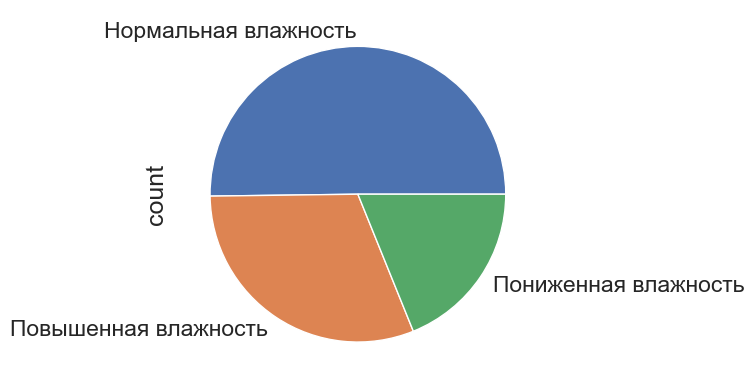

In [341]:
def rh2cat(rh):
    if 40 <= rh <= 60:
        return "Нормальная влажность"
    if rh < 40:
        return "Пониженная влажность"
    return "Повышенная влажность"

df['rh_кат'] = df['rh'].apply(rh2cat)

pd.value_counts(df['rh_кат']).plot.pie()
plt.show()

## Корреляция между параметрами (task14)

In [342]:
# Рассматриваем cущественные корреляции Номинальная-Номаинальная 


for col1, col2 in itertools.combinations(list(df.columns), 2):
    if col1 in categorial and col2 in categorial:
        if col1 == col2:
            continue

        table = pd.crosstab(df[col1], df[col2])
        if len(table) == 0:
            continue
        
        res = stats.chi2_contingency(table)
        if res[1] < 0.05:
            n = table.sum().sum()
            phi2 = res[0] / n
            kramer = np.sqrt(phi2 / (min(table.shape) - 1))
            if kramer > 0.5:
                print(col1, col2, "  K=", kramer, "  p=", res[1])

год климат   K= 0.7071067811865476   p= 5.109130746665515e-99
год город   K= 1.0   p= 8.249698737851307e-197
год страна   K= 0.9999999999999999   p= 2.259471425529061e-207
климат город   K= 1.0   p= 0.0
климат страна   K= 0.7071067811865475   p= 5.109130746665662e-99
город страна   K= 0.9999999999999999   p= 8.249698737852247e-197
способ_охлаждения отопление   K= 0.8852745960730183   p= 3.589394311695889e-15
ощущение_температуры_(bool) предпочтительное_изменение_температуры   K= 0.5206045559803226   p= 4.2928622573762964e-29
ощущение_температуры_(bool) ощущение_движения_воздуха_(bool)   K= 0.6167399054321971   p= 4.017292262600697e-18
предпочтительное_изменение_температуры ощущение_движения_воздуха_(bool)   K= 0.6415817479010723   p= 2.0046007006970044e-18
ощущение_движения_воздуха_(bool) предпочтительное_изменение_движения_воздуха   K= 0.9101818702019218   p= 2.4070229662646145e-36
занавески вентилятор   K= 0.9722007722007722   p= 1.5919561128165016e-16


- корреляции год - <что-то> являются особенностью данных (за 2010 собраны данные за один город, за 2011 за другой)
- климат - год, климат - страна: корреляции очевидны (города не перемещаются из одной климатической зоны в другую, по крайней мере в рамках наших данных)
- город - способ_охлаждения: эти данные нам также ничего не дают
- страна - <что-то>: особенности данных
- способ_охлаждение - отопление: это не имеет смысла, поскольку корреляция не видна графическим методом и данные содержат много пропусков. Если эти пропуски убрать, то pvalue значительно поднимется
- ощущение_движения_воздуха_(bool) - ощущение_температуры_(bool): видимо если людям нравится как двигается воздух, то им нравится температура
- ощущение_движения_воздуха_(bool) - предпочтительное_изменение_температуры: если людям нравится как движется воздух, то они не хотят менять температуру?
- занавески - вентилятор: наличие занавесок говорит нам о наличии вентрилятора у человека

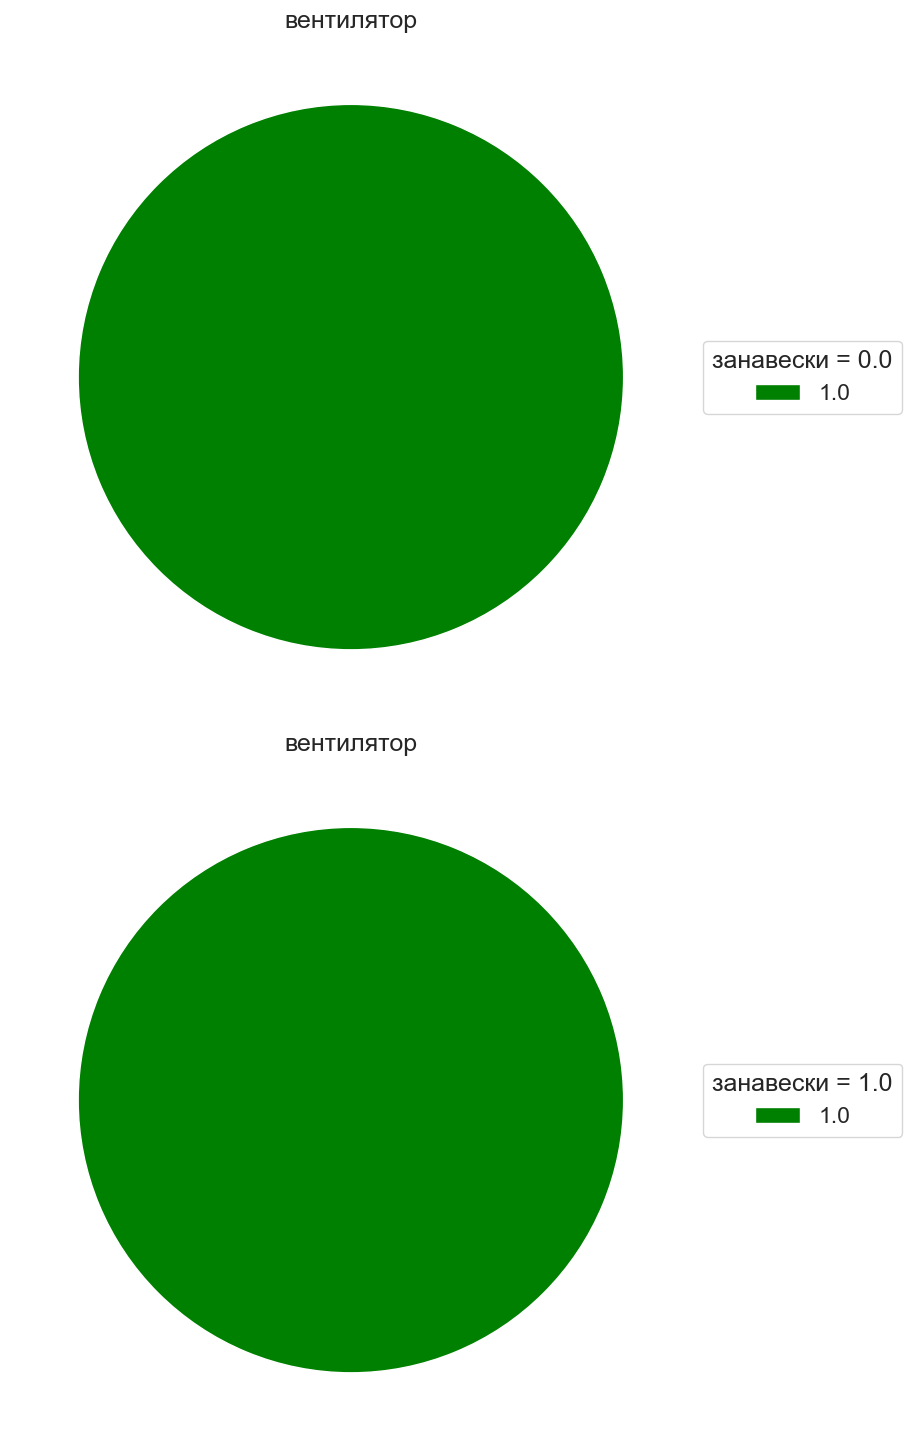

In [343]:
show_pie_charts('занавески', 'вентилятор')

In [344]:
# Рассматриваем cущественные корреляции Количественная-Номаинальная 
temp_df = df.copy()
temp_df['способ_обогрева'] = temp_df['способ_обогрева'].fillna('нет')


for col1, col2 in itertools.product(list(categorial), list(numerical), repeat=1):
    if col1 == col2:
        continue
        
    if len(temp_df[col1].unique()) <= 2:
        if stats.shapiro(temp_df[col2])[1] < 0.05:
            g1 = temp_df[temp_df[col1] == temp_df[col1].unique()[0]][col2]
            g2 = temp_df[temp_df[col1] == temp_df[col1].unique()[1]][col2]
            
            res = stats.ttest_ind(g1, g2)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1])
        else:
            g1 = temp_df[temp_df[col1] == temp_df[col1].unique()[0]][col2]
            g2 = temp_df[temp_df[col1] == temp_df[col1].unique()[1]][col2]
    
            res = stats.mannwhitneyu(g1, g2)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1])
    else:
        if stats.shapiro(temp_df[col2])[1] < 0.05:
            groups = []
            for i in temp_df[col1].unique():
                groups.append(temp_df[temp_df[col1] == i][col2])
            res = stats.f_oneway(*groups)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1])
        else:
            groups = []
            for i in temp_df[col1].unique():
                groups.append(temp_df[temp_df[col1] == i][col2])
    
            res = stats.kruskal(*groups)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1])

способ_охлаждения температура_воздуха_в_помещении   p= 0.0231753336558885
способ_охлаждения среднемесячная_температура_на_улице   p= 1.6428408831879717e-08
способ_охлаждения количество_рекламаций   p= 0.0010995220545155337
способ_охлаждения утепление   p= 0.0023370495752030253
способ_обогрева возраст   p= 7.363002265551248e-19
способ_обогрева температура_воздуха_в_помещении   p= 1.259556897446072e-13
способ_обогрева rh   p= 3.078733224330551e-27
способ_обогрева среднемесячная_температура_на_улице   p= 1.1271572022005122e-46
способ_обогрева количество_рекламаций   p= 0.0012773155692153294
способ_обогрева утепление   p= 5.629064171282537e-17
способ_обогрева ощущение_температуры   p= 8.69715797840136e-06
страна возраст   p= 3.303015844330255e-15
страна температура_воздуха_в_помещении   p= 2.259205328425065e-09
страна rh   p= 6.356158236648835e-44
страна среднемесячная_температура_на_улице   p= 3.739851875178557e-35
страна количество_рекламаций   p= 3.86440225401987e-08
страна утепление   

C:\Users\anton\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:3872: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


- ощущение_движения_воздуха_(bool) - утепление: если опрошенный считает движение воздуха хорошим, то он утепляется меньше. (средняя корреляция)

<Axes: xlabel='способ_обогрева', ylabel='среднемесячная_температура_на_улице'>

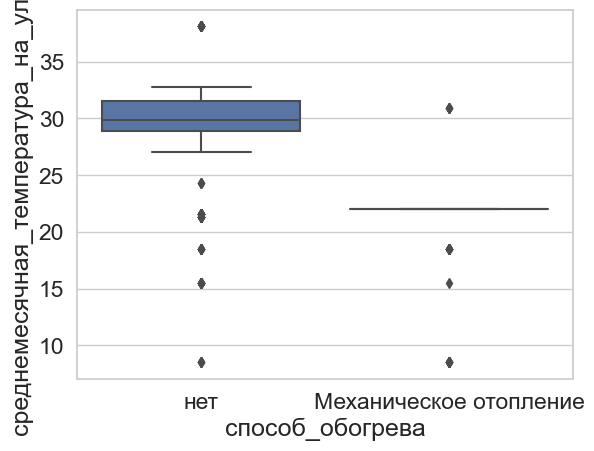

In [345]:
sns.boxplot(data=temp_df, x='способ_обогрева', y='среднемесячная_температура_на_улице')

- способ_обогрева - среднемесячная_температура_на_улице: очевидно, что от среднемесичной теспературы будет зависеть, стоит ли у людей в доме отопление или нет. (средняя корреляция)

<Axes: xlabel='пол', ylabel='рост'>

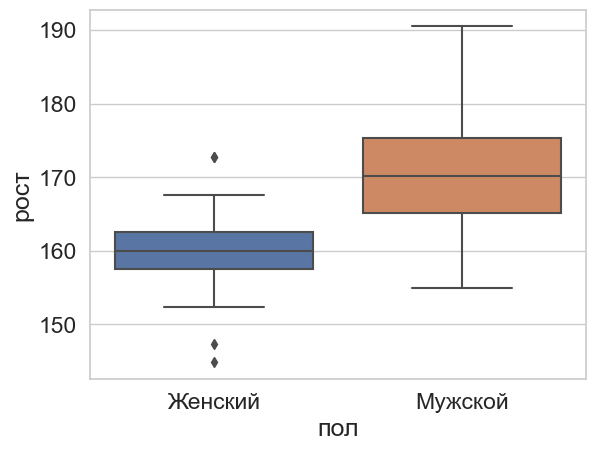

In [346]:
sns.boxplot(data=temp_df, x='пол', y='рост')

- пол - рост
- климат - утепление: в жарких краях люди не вынуждены носить много теплой одежды
- страна - среднемесячная_температура_на_улице: погода (температура) циклична

In [347]:
# Рассматриваем cущественные корреляции Количественная-Количественная

for col1, col2 in itertools.product(list(numerical), list(numerical), repeat=1):
    if col1 == col2:
        continue
    
    if stats.shapiro(df[col1])[1] < 0.05 and stats.shapiro(df[col2])[1] < 0.05:
        res = stats.pearsonr(df[col1], df[col2])
        if res[1] < 0.05 and abs(res[0]) > 0.3:
            print(col1, col2, "  p=", res[1], " r=", res[0])
    else:
        res = stats.spearmanr(df[col1], df[col2])
        if res[1] < 0.05 and abs(res[0]) > 0.3:
            print(col1, col2, "  p=", res[1], " r=", res[0])

возраст среднемесячная_температура_на_улице   p= 3.5347505760201286e-12  r= -0.3097550647997825
температура_воздуха_в_помещении среднемесячная_температура_на_улице   p= 5.268318323927442e-29  r= 0.4789197125203968
rh утепление   p= 6.531069272482034e-17  r= -0.36808287148871943
среднемесячная_температура_на_улице возраст   p= 3.5347505760201286e-12  r= -0.3097550647997825
среднемесячная_температура_на_улице температура_воздуха_в_помещении   p= 5.268318323927442e-29  r= 0.4789197125203968
утепление rh   p= 6.531069272482034e-17  r= -0.36808287148871943


- температура_воздуха_в_помещении - температура_воздуха_на_улице: логично
- рост - вес: хорошего человека должно быть много

# Проверка гипотез

## Влияет ли способ охлаждения на оценку комфорта (task 15)

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

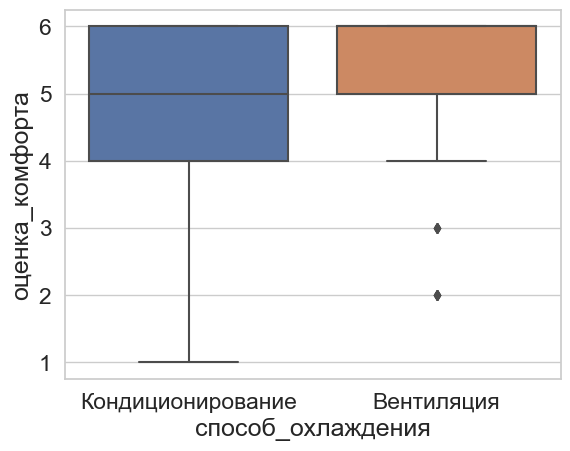

Распрление нормальное?:  False
pvalue = KruskalResult(statistic=nan, pvalue=nan)


In [348]:
temp_df = df[['способ_охлаждения', 'оценка_комфорта']].copy()
temp_df = temp_df.dropna()

sns.boxplot(x='способ_охлаждения', y='оценка_комфорта', data=temp_df)
plt.show()

# Шкалы разные: способ охлаждения - номинальная (3 уровня), оценка комфорта - количественная
# Проверка как распределена оценка комфорта

print("Распрление нормальное?: ", stats.shapiro(temp_df['оценка_комфорта'])[1] >= 0.05)

# Распределение не нормальное, поэтому применяем критерий Краскела-Уоллеса

g1 = temp_df[temp_df['способ_охлаждения'] == 'Смешанный']['оценка_комфорта']
g2 = temp_df[temp_df['способ_охлаждения'] == 'Вентиляция']['оценка_комфорта']
g3 = temp_df[temp_df['способ_охлаждения'] == 'Кондиционирование']['оценка_комфорта']
print("pvalue =", stats.kruskal(g1, g2, g3))

pvalue получилось более 0.05, значит мы не можем отвергнуть нулевую гипотезу о том, что фактор и отклик как-либо зависимы. То есть **подтвердить влияние типа охлаждения на оценку комфорта невозможно при наших данных.**

## Влияние пола на оценку комфорта (task16)

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

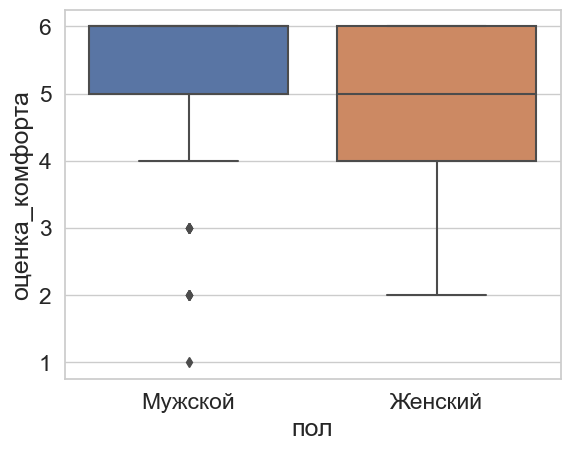

Распрление нормальное?:  False
pvalue = 0.12111267889388343
Если считать что кто оценка_комфорта это также номинальная шкала    K= 0.20188828123633423   p= 0.3232639674687969


In [349]:
temp_df = df[['пол', 'оценка_комфорта']].copy()
temp_df = temp_df.dropna()

sns.boxplot(x='пол', y='оценка_комфорта', data=temp_df)
plt.show()

# Шкалы разные: пол - номинальная (2 уровня), оценка комфорта - количественная
# Проверка как распределена оценка комфорта

print("Распрление нормальное?: ", stats.shapiro(temp_df['оценка_комфорта'])[1] >= 0.05)

# Распределение не нормальное, поэтому применяем метод Манна-Уитни

g1 = temp_df[temp_df['пол'] == 'Мужской']['оценка_комфорта']
g2 = temp_df[temp_df['пол'] == 'Женский']['оценка_комфорта']

print("pvalue =", stats.mannwhitneyu(g1, g2)[1])

# Если оценка_комфорта это номинальная шкала, то есть нужно применить хи-квадрат чтобы проверить корреляцию

table = pd.crosstab(df['пол'], df['оценка_комфорта'])

res = stats.chi2_contingency(table)

n = table.sum().sum()
phi2 = res[0] / n
kramer = np.sqrt(phi2 / (min(table.shape) - 1))
print("Если считать что кто оценка_комфорта это также номинальная шкала", "   K=", kramer, "  p=", res[1])

pvalue получилось более 0.05, значит мы не можем отвергнуть нулевую гипотезу о том, что фактор и отклик как-либо зависимы. То есть **подтвердить влияние пола на оценку комфорта невозможно при наших данных.**

## Влияет ли возрастная группа на оценку комфорта (task17)
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

<Axes: xlabel='возрастная_группа', ylabel='оценка_комфорта'>

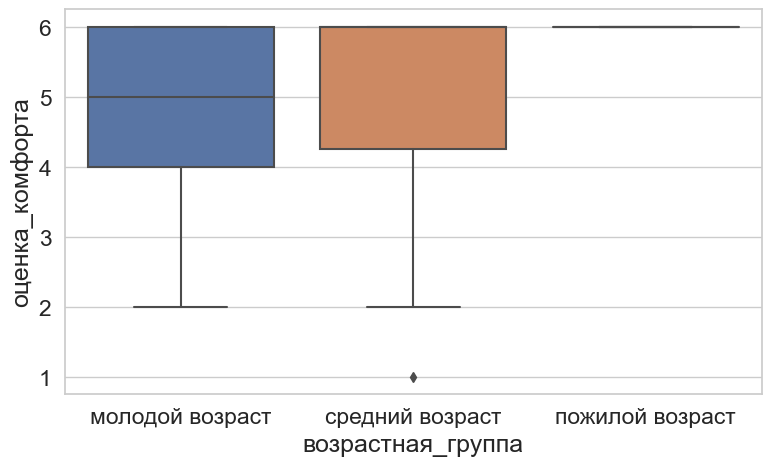

In [350]:
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(df, x='возрастная_группа', y='оценка_комфорта', ax=ax)

Поскольку `возрастная_группа` представленна в виде категориальной шкалы, а `оценка_комфорта` в количественной, то будем использовать критерий Красскела-Уоллеса или ANOVA. Для это определим нормальность распределения в столбце `оценка_комфорта` 

Распределение нормальнное, исппользуем ANOVA


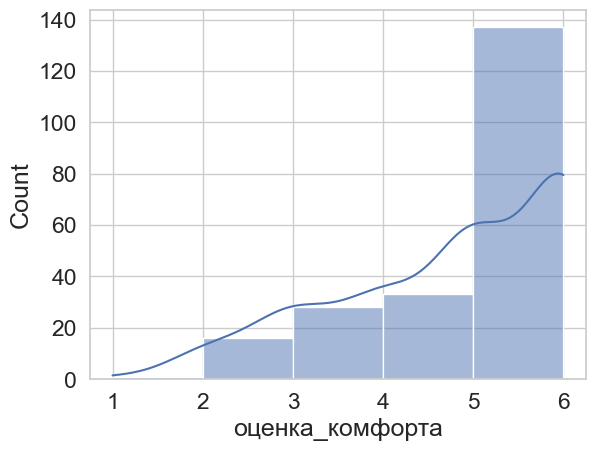

In [351]:
sns.histplot(df, x='оценка_комфорта', kde=True, bins=5)

if stats.shapiro(df['оценка_комфорта'])[1] >= 0.5:
    print('Распределение \033[1mнормальнное\033[0m, исппользуем ANOVA')
else:
    print('Распределение \033[1mненормальное\033[0m, используем критерий Красскела-Уоллеса')

In [352]:
gp = df.groupby('возрастная_группа')['оценка_комфорта']
anova = stats.f_oneway(*(v for v in gp.groups.values()))
anova

F_onewayResult(statistic=3.689780638691176, pvalue=0.02569017864655)

In [353]:
if anova[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что возрастная группа влияет на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что возрастная группа \033[1mвлияет\033[0m на оценку комфорта.')

Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что возрастная группа влияет на оценку комфорта.


## Взаимосвязь между количеством рекламаций и оценкой комфорта (task18)
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

корелляция и pvalue:  PearsonRResult(statistic=-0.5012734788364305, pvalue=4.4326444240433336e-15)


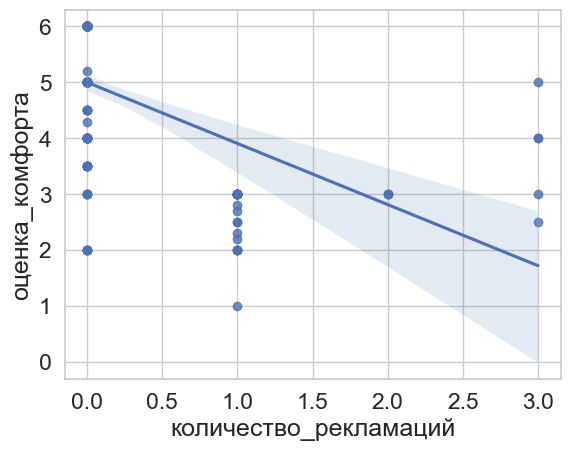

In [354]:
temp_df = df[['оценка_комфорта', 'количество_рекламаций']].copy()
temp_df = temp_df.dropna()

print("корелляция и pvalue: ", stats.pearsonr(temp_df['количество_рекламаций'], temp_df['оценка_комфорта']))

sns.regplot(df, x='количество_рекламаций', y='оценка_комфорта')
plt.show()

Корреляция (0.5) не сильная, однако и не нулевая. Pvalue намного меньше 0.05, поэтому мы можем доверять полученной корреляции. *То есть взаимосвязь есть, однако она не сильная.*

## Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны (task19)
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [355]:
pd.read_csv('Данные по использованию климатических систем.csv', sep=';').groupby('Страна')['Ощущение движения воздуха (bool)'].sum()

Страна
Австралия    149.0
Индия          0.0
США            0.0
Name: Ощущение движения воздуха (bool), dtype: float64

<Axes: xlabel='страна', ylabel='оценка_комфорта'>

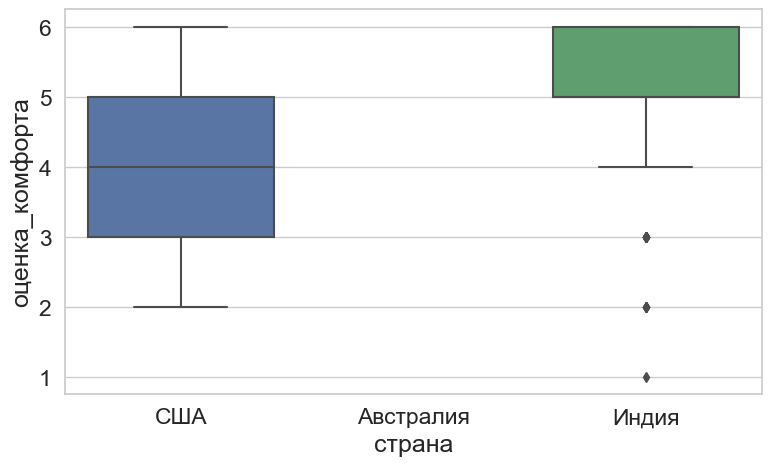

In [356]:
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(df, x='страна', y='оценка_комфорта', ax=ax)

По графику не трудно заметить, что средняя оценка у Индии больше чем у США, а у Австралии вообще нет оценок.
Впрочем это можно подтвердить математически

In [357]:
df.groupby('страна')['оценка_комфорта'].mean()

страна
Австралия         NaN
Индия        5.062937
США          4.194444
Name: оценка_комфорта, dtype: float64

Итак, средняя оценка комфортра отличается в зависимости от страны

## Выдвинуть и проверить гипотезу по влиянию разных факторов на оценку комфорта/ощущение температуры/ощущение движения воздуха (task 21)

### Оценка комфорта

**Гипотеза**
> **Категории среднемесячная температура на улице** влияет на **оценку комфорта**  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [358]:
# Поскольку колонки среднемесячная_температура_на_улице и оценка_комфорта представленны одинаковыми типами
# Так как обе колонки представлены колличественными типами, то будем использовать корреляцию пирсона
temp_df = df[['среднемесячная_температура_на_улице', 'оценка_комфорта']].copy().dropna()

temp = stats.pearsonr(temp_df['среднемесячная_температура_на_улице'], temp_df['оценка_комфорта'])

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что категория среднемесячная температура на улице влияют на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что категория среднемесячная температура на улице \033[1mвлияет\033[0m на оценку комфорта.')
print('Также можно заметить, что показатель кореляции является отрицательным, что означает, что чем ниже температура, тем больше оценка комфорта, также заметно, что модуль коэфицента корреляции') 
print('лежит между 0.1 и 0.3, что говорит об очень слабой взаимосвязи ')

PearsonRResult(statistic=-0.24845124899153878, pvalue=0.0002335656272331596)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что категория среднемесячная температура на улице влияет на оценку комфорта.
Также можно заметить, что показатель кореляции является отрицательным, что означает, что чем ниже температура, тем больше оценка комфорта, также заметно, что модуль коэфицента корреляции
лежит между 0.1 и 0.3, что говорит об очень слабой взаимосвязи 


### Ощущение температуры

**Гипотеза**
> Вес респондента влияет на его ощущение температуры  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [359]:
# Поскольку колонки среднемесячная_температура_на_улице и ощущение_температуры представленны одинаковыми типами
# Так как обе колонки представлены колличественными типами, то будем использовать корреляцию пирсона
temp_df = df[['вес', 'ощущение_температуры']].copy().dropna()

temp = stats.pearsonr(temp_df['ощущение_температуры'], temp_df['вес'])

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что вес респондента влияет на ощущение температуры.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что вес респондента \033[1mвлияет\033[0m на ощущение температуры.')

PearsonRResult(statistic=-0.00503957954645198, pvalue=0.9418506641406605)
Поскольку p-значение не меньше 0,05, мы не можем отвергнуть нулевую гипотезу.
Следовательно, у нас нет достаточных доказательств того, что вес респондента влияет на ощущение температуры.


### Ощущение движения воздуха

**Гипотеза**
> Вес респондента влияет на его ощущения движения воздуха

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

## Влияние разных факторов на оценку комфорта/ощущение температуры/ощущение движения воздуха (task 22)

### Оценка комфорта

**Гипотеза**
> **Категории относительная влажность** влияет на **оценку комфорта**  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [360]:
# Поскольку колонки rh_кат и оценка_комфорта представленны разными типами
# А в rh_кат более двух уровней, будем использовать ANOVA или критерий Красскела-Уоллеса

temp_df = df[['rh_кат', 'оценка_комфорта']].copy().dropna()

gp = temp_df.groupby('rh_кат')
if stats.shapiro(temp_df.оценка_комфорта)[1] >= 0.5:
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что категории относительной влажности влияют на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что категории относительной влажности \033[1mвлияет\033[0m на оценку комфорта.')

KruskalResult(statistic=38.52266293274033, pvalue=4.3142969109534216e-09)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что категории относительной влажности влияет на оценку комфорта.


### Ощущение температуры

**Гипотеза**
> принадлежность респондента к возрастной группе влияет на его ощущение температуры  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [361]:
# Поскольку колонки возрастная_группа и ощущение_температуры представленны разными типами
# А в возрастная_группе более двух уровней, будем использовать ANOVA или критерий Красскела-Уоллеса

temp_df = df[['возрастная_группа', 'ощущение_температуры']].copy().dropna()

gp = temp_df.groupby("возрастная_группа")
if stats.shapiro(temp_df.ощущение_температуры)[1] >= 0.5:
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что принадлежность к возрастной группе влияет на оценку комфорта')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что принадлежность к возрастной группе влияет на оценку комфорта.')

KruskalResult(statistic=7.2979402446489985, pvalue=0.026017910250498436)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что принадлежность к возрастной группе влияет на оценку комфорта.


### Ощущение движения воздуха

**Гипотеза**
> Пренадлежность респондента к возрастной групп влияет на его ощущения движения воздуха

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [362]:
temp_df = df[['ощущение_движения_воздуха_(bool)', 'возрастная_группа']].copy().dropna()

crosstab = pd.crosstab(temp_df['ощущение_движения_воздуха_(bool)'], temp_df['возрастная_группа'])
chi2 = stats.chi2_contingency(crosstab)[0]
n = crosstab.sum().sum()
phi2 = chi2 / n
kramer = np.sqrt(phi2 / (min(crosstab.shape) - 1))

print(kramer)

0.17909519344181102


Корреляция есть, но она очень слабая. Поэтому нельзя отвергнуть нулевую гипотезу.
Следовательно, на основаниии имеющихся данных нельзя сказать, что Пренадлежность респондента к возрастной групп влияет на его ощущения движения воздуха

## Какая скорость воздуха будет комфортной, и есть ли корреляция оценки воздуха с его реальной скоростью(task20)

<Axes: xlabel='ощущение_движения_воздуха_(bool)', ylabel='скорость_воздуха'>

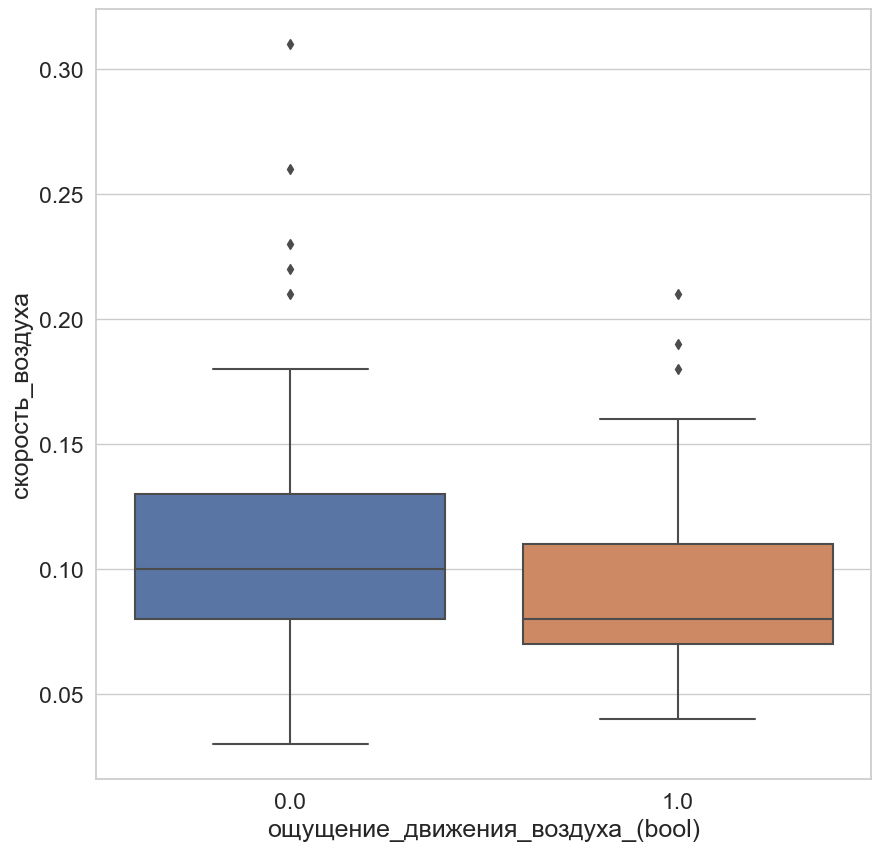

In [363]:
temp_df = df[['ощущение_движения_воздуха_(bool)', 'скорость_воздуха']].copy().dropna()

plt.figure(figsize=(10,10))
sns.boxplot(data=temp_df, x='ощущение_движения_воздуха_(bool)', y='скорость_воздуха')

In [364]:
_, p = stats.shapiro(temp_df['скорость_воздуха'])

if p > 0.05:
    print('распределение нормальное')
else:
    print('распределение ненормальное')

# Распределение ненормальное поэтому используем метод Манна-Уитни, чтобы исследовать корреляцию

g1 = temp_df[temp_df['ощущение_движения_воздуха_(bool)'] == 1]['скорость_воздуха']
g2 = temp_df[temp_df['ощущение_движения_воздуха_(bool)'] == 0]['скорость_воздуха']

_, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
print('pvalue = ', p)

распределение ненормальное
pvalue =  0.004529414866412486


pvalue меньше 0.05, поэтому мы отвергаем нулевую гипотезу и принимаем альтернативную, что ***распределния не равны и имеют статистически значимые отличия*** </br> Также по графику обратим внимание на медианы и распределение в целом: ***чем меньше скорость воздуха, тем больше шанс, что респондента устраивает скорость воздуха в помещении***

<Axes: xlabel='оценка_комфорта', ylabel='скорость_воздуха'>

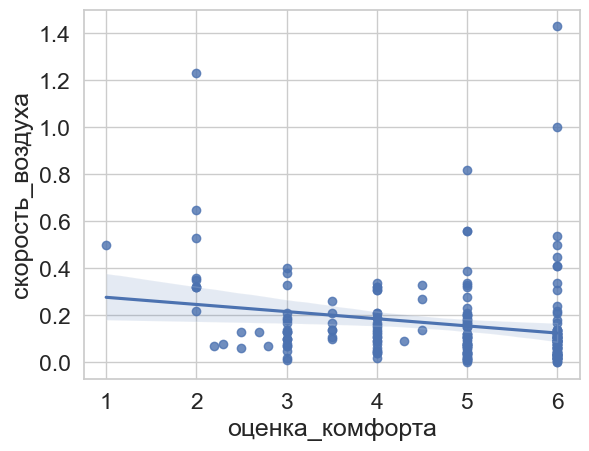

In [365]:
temp_df = df[['оценка_комфорта', 'скорость_воздуха']].copy().dropna()

sns.regplot(data=temp_df, x='оценка_комфорта', y='скорость_воздуха')

In [366]:
_, p = stats.shapiro(temp_df['скорость_воздуха'])

if p > 0.05:
    print('распределение нормальное')
else:
    print('распределение ненормальное')

# Распределение ненормальное поэтому используем корреляцию Спирмена

_, p = stats.spearmanr(temp_df['скорость_воздуха'], temp_df['оценка_комфорта'])
print('pvalue = ', p)
temp_df['скорость_воздуха'].corr(temp_df['оценка_комфорта'], method='spearman')

распределение ненормальное
pvalue =  2.4341269002141024e-05


-0.2902005376576328

Значимой корреляции между скоростью воздуха и оценкой комфорта нет (0.29 не сильная корреляция), ***поэтому сделать вывод о влиянии скорости на оценку комфорта нельзя***

# Регрессионное моделирование
Чтобы построить рабочую модель для предсказания температуры, необходимо выявить все факторы, которые могут влиять на температуру, то есть найти корреляции между факторами. </br>
Нужные факторы можно выбрать, основываясь на подтвержденные гипотезы и сильные корреляции выше. </br></br>
Для построения модели будем использовать такие факторы как: **страна, климат, время года, город**, поскольку эти факторы имеют статистически значимые корреляции с температурой воздуха в помещении(pvalue меньше 0.05) и эти факторы не будут являться утечкой, так как эти данные можно легко найти при необходимости. </br>

In [367]:
df

,год,время_года,климат,город,страна,способ_охлаждения,способ_обогрева,возраст,пол,ощущение_температуры,...,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,количество_рекламаций_кат,возрастная_группа,rh_кат
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,22.0,NaN,0.0,...,1.0,1.0,NaN,NaN,NaN,28.9,0,мало,молодой возраст,Нормальная влажность
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,40.0,NaN,-2.0,...,0.0,0.0,NaN,NaN,NaN,31.7,0,мало,молодой возраст,Пониженная влажность
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,42.0,NaN,1.0,...,0.0,0.0,NaN,NaN,NaN,32.8,0,мало,молодой возраст,Пониженная влажность
3,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,27.0,NaN,-0.5,...,1.0,1.0,NaN,NaN,NaN,28.9,1,мало,молодой возраст,Нормальная влажность
4,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,46.0,NaN,0.0,...,1.0,1.0,NaN,NaN,NaN,32.8,0,мало,средний возраст,Пониженная влажность
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,2012.0,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Вентиляция,NaN,35.0,Мужской,1.0,...,NaN,NaN,0.0,0.0,NaN,21.6,0,мало,молодой возраст,Пониженная влажность
478,2012.0,Лето,Тропическая влажная саванна,Ченнай,Индия,Кондиционирование,NaN,35.0,Мужской,1.0,...,NaN,NaN,0.0,0.0,NaN,38.1,0,мало,молодой возраст,Нормальная влажность
479,2012.0,Лето,Влажный субтропический муссонный,Дели,Индия,Вентиляция,NaN,35.0,Мужской,0.0,...,NaN,1.0,1.0,NaN,0.0,30.9,0,мало,молодой возраст,Повышенная влажность
480,2012.0,Зима,Тропическая влажная саванна,Ченнай,Индия,Кондиционирование,NaN,35.0,Мужской,-1.0,...,NaN,NaN,0.0,0.0,NaN,30.8,0,мало,молодой возраст,Повышенная влажность


In [380]:
temp_df = df[['город', 'время_года', 'способ_охлаждения',  'температура_воздуха_в_помещении']].copy()

temp_df

,город,время_года,способ_охлаждения,температура_воздуха_в_помещении
0,Техас,Лето,Кондиционирование,22.9
1,Техас,Лето,Кондиционирование,24.1
2,Техас,Лето,Кондиционирование,25.6
3,Техас,Лето,Кондиционирование,24.2
4,Техас,Лето,Кондиционирование,23.8
...,...,...,...,...
477,Хайдарабад,Зима,Вентиляция,29.5
478,Ченнай,Лето,Кондиционирование,28.8
479,Дели,Лето,Вентиляция,24.0
480,Ченнай,Зима,Кондиционирование,26.5


416    Кондиционирование
472           Вентиляция
181    Кондиционирование
444    Кондиционирование
297           Вентиляция
             ...        
218    Кондиционирование
392           Вентиляция
321    Кондиционирование
334    Кондиционирование
126    Кондиционирование
Name: способ_охлаждения, Length: 97, dtype: object
MAE: 0.971960466065574
MSE: 1.753545625804706
RMSE: 1.3242150980126703
R2: 0.512510517245457


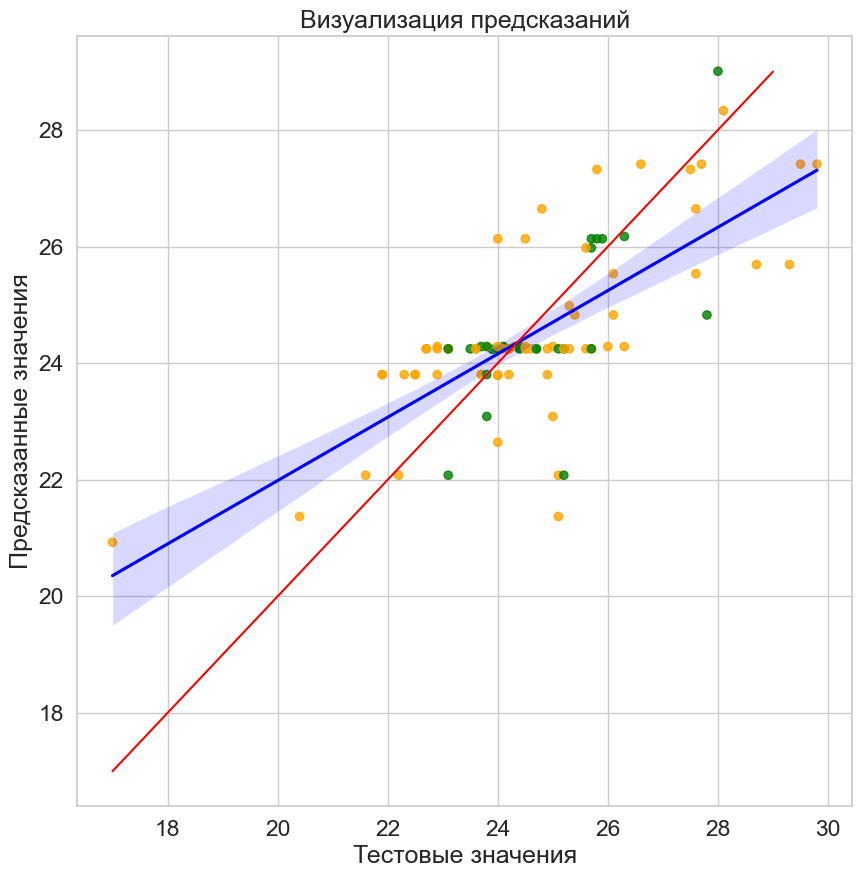

In [406]:
# Тестовая и тренировочные выборки
X_train, X_test, y_train, y_test = train_test_split(temp_df[['город', 'время_года', 'способ_охлаждения']], temp_df['температура_воздуха_в_помещении'], test_size=0.2, random_state=42)

def color_func(x):
    if x == 'Кондиционирование':
        return 'orange'
    elif x == 'Вентиляция':
        return 'green'
    else:
        return 'blue'

colors = []
for i in range(len(temp_df)):
    try:
        colors.append(color_func(X_test['способ_охлаждения'][i]))
    except:
        pass

# Кодирование категориальных признаков
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[['город', 'время_года', 'способ_охлаждения']])
X_train = encoder.transform(X_train[['город', 'время_года', 'способ_охлаждения']])
X_test = encoder.transform(X_test[['город', 'время_года', 'способ_охлаждения']])

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка модели
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

# Визуализация

plt.figure(figsize=(10,10))
sns.regplot(x=y_test, y=y_pred, color='blue', scatter_kws={'color': colors})
plt.plot(np.arange(17, 30), np.arange(17, 30), color='red')
plt.xlabel('Тестовые значения')
plt.ylabel('Предсказанные значения')
plt.title('Визуализация предсказаний')
plt.show()

# Выводы

In [371]:
df['климат_способ'] = df['климат'] + '_' + df['способ_охлаждения']

In [372]:
temp_df = df[['климат_способ', 'оценка_комфорта']].copy().dropna()
# --------------------------------------------------------------------------------------------------------------------------

if stats.shapiro(temp_df.оценка_комфорта)[1] >= 0.5:
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

KruskalResult(statistic=7.2979402446489985, pvalue=0.026017910250498436)


In [373]:
#backup test

<Axes: xlabel='оценка_комфорта', ylabel='климат_способ'>

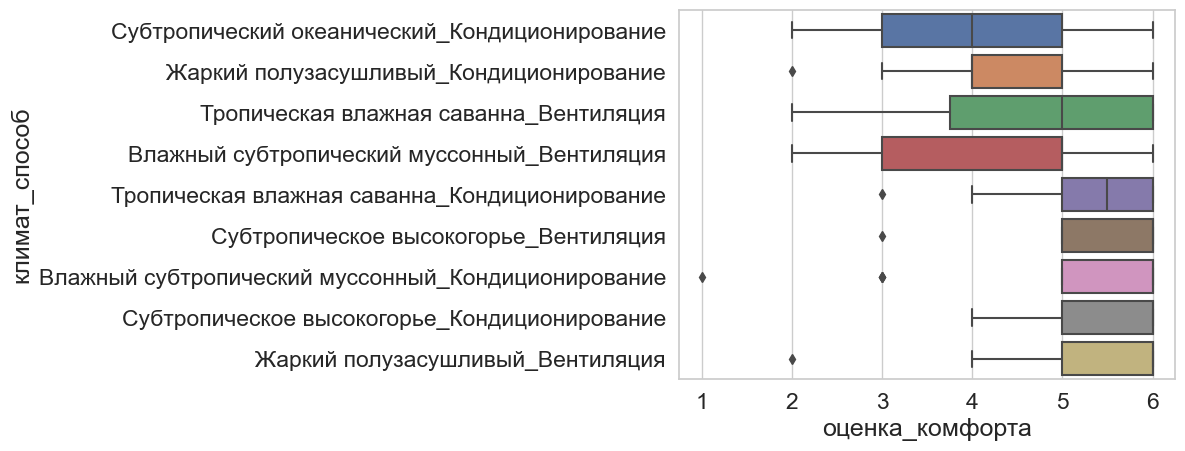

In [374]:
sns.boxplot(temp_df, x='оценка_комфорта', y='климат_способ', order=sorted(temp_df['климат_способ'].unique(), key=lambda x: temp_df[temp_df['климат_способ'] == x]['оценка_комфорта'].median()))